In [1]:
import os
import gc
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from typing import Any

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models 
from transformers import ViTModel, get_cosine_schedule_with_warmup
import torchmetrics
from torchvision.utils import make_grid
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks.callback import Callback
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.classification import MulticlassConfusionMatrix

C:\ProgramData\Anaconda3\envs\torch_gpu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
import torch.optim as optim
from torchvision import transforms, models
from torchmetrics import Accuracy # Better for metrics in PL
from transformers import AutoImageProcessor

In [5]:
#Disabling symlinks warning while using huggingface transformers model
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

### Initial Data Transforms

In [6]:
#Hardcoding the mean and std values; these were calculated in nb 1
mean = [0.4764, 0.4491, 0.4001]
std = [0.2264, 0.2224, 0.2212]

In [7]:
augment_transform=transforms.Compose([
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    
        transforms.RandomRotation(20),      # rotate +/- 20 degrees
        # transforms.RandomHorizontalFlip(p=0.25),  # flip 24% of images
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  
        # transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
        # transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, 
        #                                                saturation=0.2)], p=0.5), # jitters by +/- given value
        # transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.7))], p=0.3)
    ])
#https://docs.pytorch.org/vision/main/transforms.html

### Defining Parameters

In [8]:
# Setting the dataset path
dataset_path = "E:\\mini_ImageNet\\archive\\"

# Define the model name early
MODEL_NAME = "google/vit-base-patch16-224"

#Define batch size and number of workers
BATCH_SIZE = 16
NUM_WORKERS = 8

### Custom Image Dataset

In [9]:
### Creating a Custom Image Dataset to provide data in the way Hugging Face models expect them
class CustomImageDataset(Dataset):
    def __init__(self, data_dir, hf_image_processor, transform=None):
        self.data_dir = data_dir
        self.hf_image_processor = hf_image_processor
        self.transform = transform # This will be for *additional* augmentations
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = [] # This will store the cleaned class names for plotting

        for idx, class_name in enumerate(sorted(os.listdir(data_dir))):
            class_path = os.path.join(data_dir, class_name)
            if os.path.isdir(class_path):
                self.class_to_idx[class_name] = idx
                # If your folder names are already clean, simplify this line.
                cleaned_class_name = '_'.join(class_name.split('_')[:-1]) if '_' in class_name else class_name
                self.idx_to_class.append(cleaned_class_name)
        
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                        self.image_paths.append(os.path.join(class_path, img_name))
                        self.labels.append(idx)

        self.num_classes = len(self.idx_to_class)
        self.class_names = self.idx_to_class # Expose class names easily

    def __len__(self):
        return len(self.image_paths)
    
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # print(f"[Worker] PID={os.getpid()} loading idx={idx}")
        # print(f"[INFO] Loading image at index {idx}: {img_path}")

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"[ERROR] Failed to open image: {img_path} — {e}")
            return {
                "pixel_values": torch.zeros((3, 224, 224)),
                "labels": torch.tensor(0)
            }
        
        #Applying the pytorch data augmentation transforms before using the HF image processor
        if self.transform:
            try:
                image = self.transform(image)
            except Exception as e:
                print(f"[ERROR] Transform failed: {img_path} — {e}")
                return {
                    "pixel_values": torch.zeros((3, 224, 224)),
                    "labels": torch.tensor(0)
                }

        try:
            inputs = self.hf_image_processor(images=image, return_tensors="pt")
            pixel_values = inputs["pixel_values"].squeeze()
        except Exception as e:
            print(f"[ERROR] HF processor failed: {img_path} — {e}")
            pixel_values = torch.zeros((3, 224, 224))

        return {
            "pixel_values": pixel_values,
            "labels": torch.tensor(label, dtype=torch.long)
        }


In [10]:
# Initialize the image processor
hf_image_processor = AutoImageProcessor.from_pretrained(MODEL_NAME, use_fast=True)

In [11]:
#Function to update the data transforms used
def get_augment_transform(epoch):
    mean = [0.4764, 0.4491, 0.4001]
    std = [0.2264, 0.2224, 0.2212]

    # Phase 1: Light augmentation
    if epoch < 2:
        return transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(p=0.25),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

    # Phase 2: Medium augmentation
    elif epoch < 5:
        return transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(p=0.25),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

    # Phase3: Stronger augmentations
    else:
        return transforms.Compose([
            transforms.Resize(224),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(p=0.25),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            transforms.RandomRotation(20),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.7))], p=0.3),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

### Data Module

In [12]:
class DataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str, hf_image_processor, batch_size: int = 32, num_workers: int = 4, augment_transform=None):
        super().__init__()
        self.data_dir = data_dir
        self.hf_image_processor = hf_image_processor
        self.augment_transform = augment_transform # For optional data augmentation
        self.batch_size = batch_size
        self.num_w = num_workers
        self._num_classes = None
        self._class_names = None
    
    def setup(self, stage=None):
        # Initialize CustomImageDataset with the Hugging Face processor
        full_dataset = CustomImageDataset(data_dir=self.data_dir,
                                          hf_image_processor=self.hf_image_processor,
                                          transform=self.augment_transform)

        n_data = len(full_dataset)
        n_train = int(0.7 * n_data)
        n_valid = int(0.2 * n_data)
        n_test = n_data - n_train - n_valid

        # Ensure that the split sum equals n_data
        if n_train + n_valid + n_test != n_data:
            n_train = n_data - n_valid - n_test

        self.train_dataset, self.val_dataset, self.test_dataset = random_split(full_dataset, [n_train, n_valid, n_test])

        self._num_classes = full_dataset.num_classes
        self._class_names = full_dataset.class_names # Store class names

    @property
    def num_classes(self):
        if self._num_classes is None:
            raise RuntimeError("num_classes not set. Call setup() first.")
        return self._num_classes

    @property
    def class_names(self):
        if self._class_names is None:
            raise RuntimeError("class_names not set. Call setup() first.")
        return self._class_names
    

    def update_transform(self, new_transform):
        self.train_dataset.dataset.transform = new_transform

    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, 
                          num_workers=self.num_w, persistent_workers=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, 
                  num_workers=self.num_w, 
                          persistent_workers=False) #Modifying this to False to run it on an ipynb file

### Classifier that uses the ViT model

In [13]:
class ViTClassifier(pl.LightningModule):
    
    def __init__(self, model_name: str, num_labels: int, class_labels: list, learning_rate: float = 1e-4):
        super().__init__()
        #self.save_hyperparameters() # Automatically saves all __init__ arguments as hyperparameters

        self.test_preds = []
        self.test_targets = []
        self.class_labels = class_labels # Store class names for plotting
        self.learning_rate = learning_rate

        self.confmat = MulticlassConfusionMatrix(num_classes=num_labels)
                
        self.backbone = ViTModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.backbone.config.hidden_size, num_labels)
        
        # Define metrics
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_labels)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_labels)
        self.test_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_labels)
        
        self.loss_fn = nn.CrossEntropyLoss()
    

    def forward(self, x): # 'x' is the pixel_values tensor
        outputs = self.backbone(pixel_values=x)
        cls_token = outputs.last_hidden_state[:, 0, :]  # CLS token
        logits = self.classifier(cls_token)
        return logits
        

    def training_step(self, batch, batch_idx):
        inputs = batch["pixel_values"] # Unpack dictionary
        labels = batch["labels"]       # Unpack dictionary

        logits = self.forward(inputs)
        loss = self.loss_fn(logits, labels)

        preds = torch.argmax(logits, dim=-1)
        self.train_accuracy.update(preds, labels)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", self.train_accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss


    def validation_step(self, batch, batch_idx):
        inputs = batch["pixel_values"]
        labels = batch["labels"]
        
        logits = self.forward(inputs)
        loss = self.loss_fn(logits, labels)

        preds = torch.argmax(logits, dim=-1)
        self.val_accuracy.update(preds, labels)

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", self.val_accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss
    

    def test_step(self, batch, batch_idx):
        inputs = batch["pixel_values"]
        labels = batch["labels"]

        logits = self.forward(inputs)
        loss = self.loss_fn(logits, labels)

        preds = torch.argmax(logits, dim=-1)
        self.test_accuracy.update(preds, labels)

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_acc", self.test_accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        self.test_preds.append(preds.detach().cpu())
        self.test_targets.append(labels.detach().cpu())

        return loss


    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=0.01)
        num_training_steps = self.trainer.estimated_stepping_batches
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1 * num_training_steps),
            num_training_steps=num_training_steps,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
            }
        }
    

    def on_test_epoch_end(self):
        # Concatenate all predictions and targets
        all_preds = torch.cat(self.test_preds)
        all_targets = torch.cat(self.test_targets)

        device = self.device
        self.confmat = self.confmat.to(device)
        all_preds = all_preds.to(device)
        all_targets = all_targets.to(device)

        # Update and compute confusion matrix
        self.confmat.update(all_preds, all_targets)
        conf_matrix = self.confmat.compute()

        # Plot
        class_names_ = self.class_labels # Use the stored class names
        num_classes = len(class_names_)
        fig_size = max(10, num_classes * 0.3) # Adjust figure size dynamically

        plt.figure(figsize=(fig_size, fig_size))
        sns.heatmap(conf_matrix.cpu().numpy(),
                    annot=False, # Set to True if you want numbers in cells (can be cluttered for many classes)
                    cmap='Blues',
                    fmt='d',
                    xticklabels=class_names_,
                    yticklabels=class_names_)

        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.xticks(rotation=90, fontsize=max(6, 100 / num_classes)) # Adjust font size based on number of classes
        plt.yticks(rotation=0, fontsize=max(6, 100 / num_classes))
        plt.tight_layout()
        plt.show()

        # Reset confusion matrix and buffers
        self.confmat.reset()
        self.test_preds.clear()
        self.test_targets.clear()
        self.final_confusion_matrix = conf_matrix.clone().detach().cpu()

In [14]:
#Setting the seed before the dataset is initialized
pl.seed_everything(42, workers=True)  # `workers=True` ensures worker-level reproducibility

Seed set to 42


42

In [15]:
#Initialize the data module
data_module = DataModule(
                    data_dir=dataset_path,
                    hf_image_processor=hf_image_processor,
                    batch_size=BATCH_SIZE,
                    num_workers=0,
                    augment_transform=augment_transform
                )

In [16]:
data_module.setup() # Crucial to call setup here to get num_classes
num_classes = data_module.num_classes
class_names = data_module.class_names
print(f"Number of classes: {num_classes}")

Number of classes: 50


In [17]:
model_path = "D:\\Code\\Mini Imagenet Classification\\ResNet and ViT\\ViT\\checkpoints\\2025-06-18_02-40-42\\epochepoch=09-val_lossval_loss=0.34.ckpt"
model_path

'D:\\Code\\Mini Imagenet Classification\\ResNet and ViT\\ViT\\checkpoints\\2025-06-18_02-40-42\\epochepoch=09-val_lossval_loss=0.34.ckpt'

In [18]:
# Initialize classifier
model = ViTClassifier.load_from_checkpoint(model_path,
                                          model_name=MODEL_NAME, 
                                          num_labels=num_classes,
                                          class_labels=class_names)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
model.eval()

ViTClassifier(
  (confmat): MulticlassConfusionMatrix()
  (backbone): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072

In [20]:
trainer = pl.Trainer(
    accelerator='gpu', # Use 'gpu' if you know it's available, 'cpu' otherwise; 'auto' if unsure
    devices=1,          # Number of GPUs/CPUs to use
    logger=False,       # Don't log to TensorBoard during testing if not needed
    enable_checkpointing=False # Don't save checkpoints during testing
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [21]:
for i in range(len(data_module.test_dataset)):
    sample = data_module.test_dataset[i]
    if sample["pixel_values"].sum() == 0:
        print(f"Problem at index {i}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\envs\torch_gpu_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0:   1%|▎                                                           | 1/188 [00:00<02:48,  1.11it/s]

C:\ProgramData\Anaconda3\envs\torch_gpu_env\lib\site-packages\pytorch_lightning\core\module.py:512: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
C:\ProgramData\Anaconda3\envs\torch_gpu_env\lib\site-packages\pytorch_lightning\core\module.py:512: You called `self.log('test_acc', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Testing DataLoader 0: 100%|██████████████████████████████████████████████████████████| 188/188 [01:11<00:00,  2.63it/s]

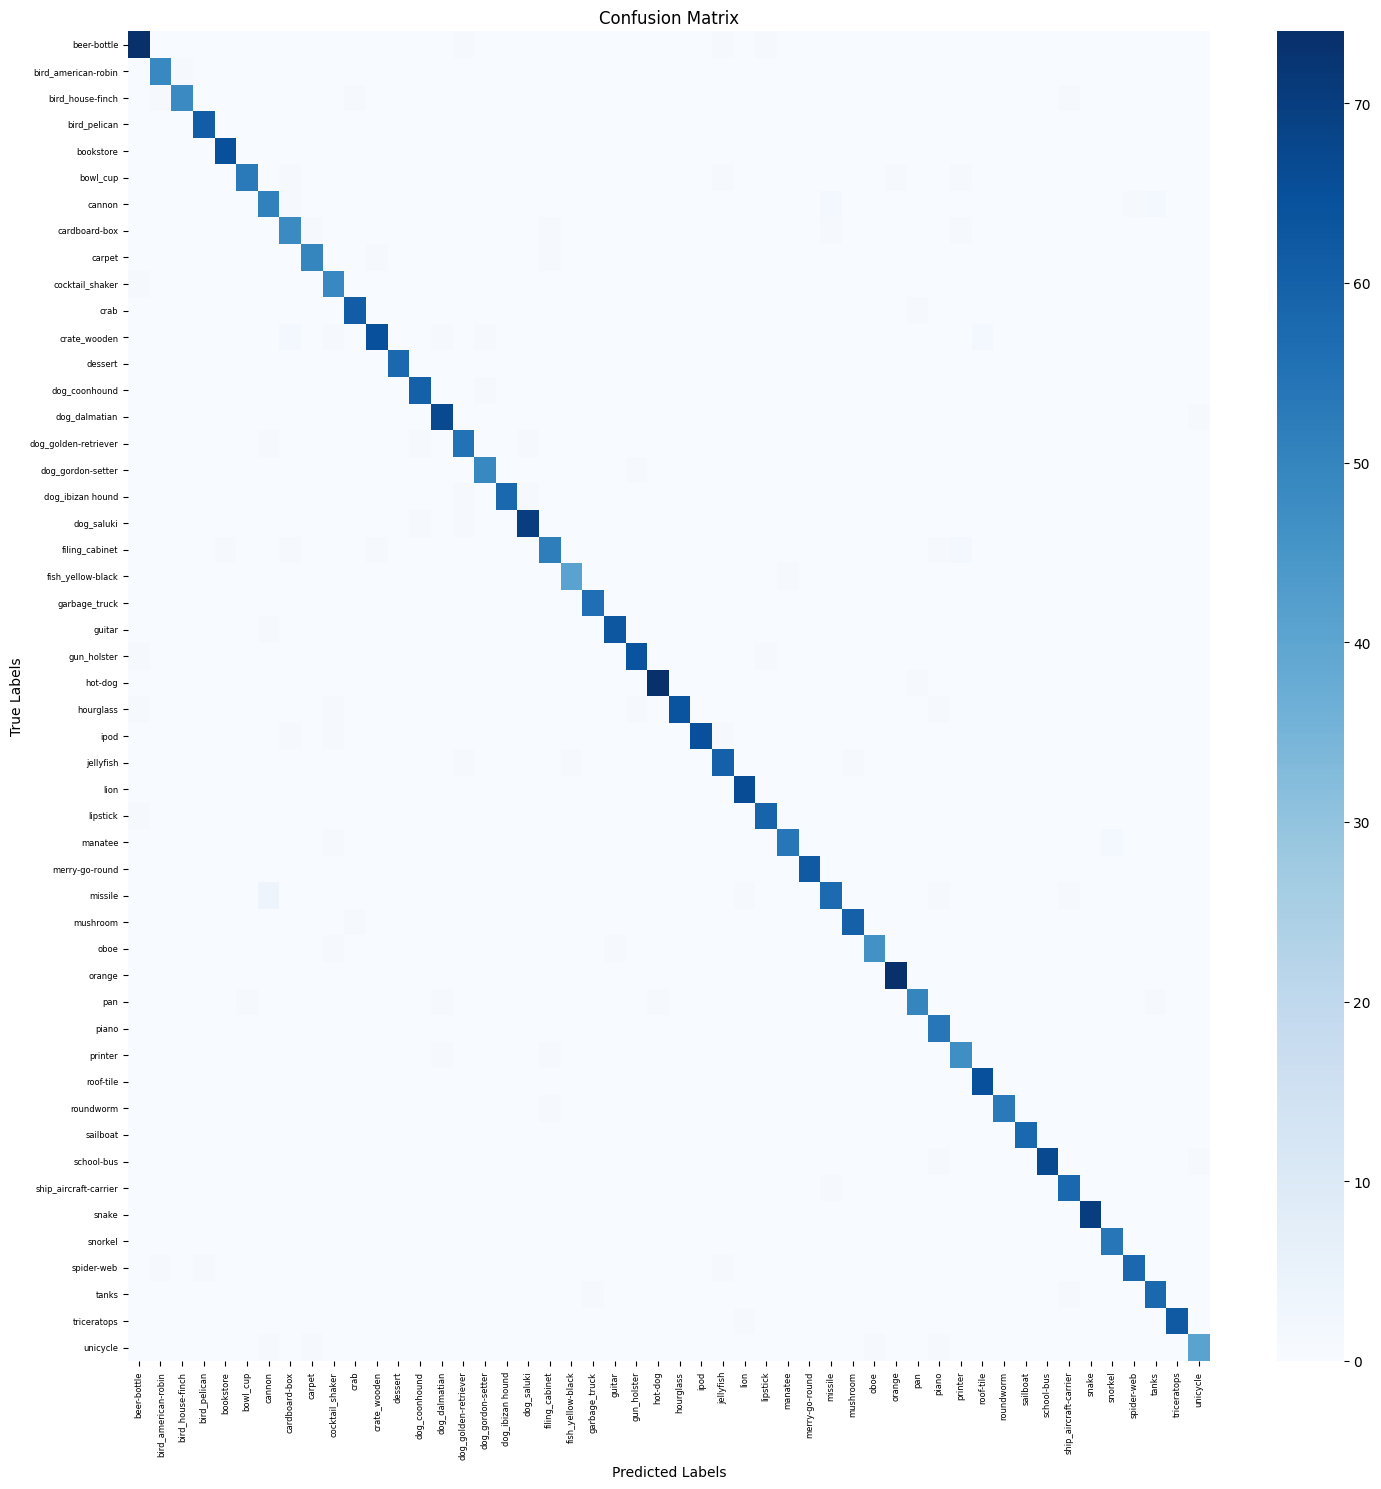

Testing DataLoader 0: 100%|██████████████████████████████████████████████████████████| 188/188 [01:12<00:00,  2.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9676666855812073
        test_loss           0.1118529662489891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [22]:
test_results = trainer.test(model, datamodule=data_module)

### Test Accuracy: 96.77%

In [23]:
conf_matrix = model.final_confusion_matrix
print(conf_matrix)

tensor([[74,  0,  0,  ...,  0,  0,  0],
        [ 0, 49,  1,  ...,  0,  0,  0],
        [ 0,  1, 48,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ..., 58,  0,  0],
        [ 0,  0,  0,  ...,  0, 62,  0],
        [ 0,  0,  0,  ...,  0,  0, 41]])


In [24]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [25]:
df_conf_matrix = pd.DataFrame(conf_matrix)
df_conf_matrix['class_names'] = class_names
df_conf_matrix = df_conf_matrix.set_index('class_names')

for idx, col in enumerate(df_conf_matrix.columns):
    df_conf_matrix.rename(columns={col:class_names[idx]}, inplace=True)

In [26]:
df_conf_matrix

,beer-bottle,bird_american-robin,bird_house-finch,bird_pelican,bookstore,bowl_cup,cannon,cardboard-box,carpet,cocktail_shaker,crab,crate_wooden,dessert,dog_coonhound,dog_dalmatian,dog_golden-retriever,dog_gordon-setter,dog_ibizan hound,dog_saluki,filing_cabinet,fish_yellow-black,garbage_truck,guitar,gun_holster,hot-dog,hourglass,ipod,jellyfish,lion,lipstick,manatee,merry-go-round,missile,mushroom,oboe,orange,pan,piano,printer,roof-tile,roundworm,sailboat,school-bus,ship_aircraft-carrier,snake,snorkel,spider-web,tanks,triceratops,unicycle
class_names,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
beer-bottle,74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
bird_american-robin,0,49,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
bird_house-finch,0,1,48,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
bird_pelican,0,0,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
bookstore,0,0,0,0,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
bowl_cup,0,0,0,0,0,53,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
cannon,0,0,0,0,0,0,51,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0
cardboard-box,0,0,0,0,0,0,0,48,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
carpet,0,0,0,0,0,0,0,0,50,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
